In [1]:
import os
import jax
import mujoco
from mujoco import mjx
from utils import get_root_path

xml_file = "arm.xml"

mj_dir = os.path.join(get_root_path(), "mujoco")
xml_path = os.path.join(mj_dir, xml_file)
mj_model = mujoco.MjModel.from_xml_path(xml_path)
mjx_model = mjx.put_model(mj_model)

@jax.vmap
def batched_step(vel):
  mjx_data = mjx.make_data(mjx_model)
  qvel = mjx_data.qvel.at[0].set(vel)
  mjx_data = mjx_data.replace(qvel=qvel)
  pos = mjx.step(mjx_model, mjx_data).qpos[0]
  return pos

vel = jax.numpy.arange(0.0, 1.0, 0.01)
pos = jax.jit(batched_step)(vel)
print(pos)

[0.0000000e+00 1.9987225e-05 3.9974973e-05 5.9963244e-05 7.9952035e-05
 9.9941346e-05 1.1993119e-04 1.3992155e-04 1.5991245e-04 1.7990384e-04
 1.9989576e-04 2.1988823e-04 2.3988119e-04 2.5987471e-04 2.7986875e-04
 2.9986326e-04 3.1985831e-04 3.3985393e-04 3.5985003e-04 3.7984669e-04
 3.9984379e-04 4.1984153e-04 4.3983970e-04 4.5983845e-04 4.7983768e-04
 4.9983751e-04 5.1983778e-04 5.3983851e-04 5.5983994e-04 5.7984178e-04
 5.9984415e-04 6.1984709e-04 6.3985051e-04 6.5985444e-04 6.7985896e-04
 6.9986394e-04 7.1986939e-04 7.3987554e-04 7.5988210e-04 7.7988912e-04
 7.9989678e-04 8.1990490e-04 8.3991355e-04 8.5992267e-04 8.7993243e-04
 8.9994271e-04 9.1995340e-04 9.3996472e-04 9.5997646e-04 9.7998884e-04
 1.0000017e-03 1.0200151e-03 1.0400289e-03 1.0600432e-03 1.0800582e-03
 1.1000738e-03 1.1200897e-03 1.1401061e-03 1.1601232e-03 1.1801407e-03
 1.2001587e-03 1.2201775e-03 1.2401965e-03 1.2602162e-03 1.2802363e-03
 1.3002570e-03 1.3202782e-03 1.3403000e-03 1.3603222e-03 1.3803450e-03
 1.400

In [2]:
mj_data = mujoco.MjData(mj_model)

for v in vel:
  mujoco.mj_resetData(mj_model, mj_data)
  mujoco.mj_forward(mj_model, mj_data)
  mj_data = mujoco.MjData(mj_model)
  mj_data.qvel[0] = v
  mujoco.mj_step(mj_model, mj_data)
  pos = mj_data.qpos[0]
  print(pos)

0.0
1.9987224307224948e-05
3.9974971377822966e-05
5.996324121179406e-05
7.995203380913822e-05
9.994134544650656e-05
0.00011993118729394576
0.0001399215519049528
0.0001599124318322456
0.00017990383452271672
0.0001998957599763662
0.00021988822308892652
0.00023988119406932214
0.00025987468781289605
0.00027986871921654934
0.0002998632435895789
0.0003198583205203678
0.00033985392021511395
0.00035985001287689957
0.00037984665809878145
0.0003998437962861447
0.00041984148703516215
0.00043983970054813694
0.00045983840702425616
0.0004798376660643666
0.0004998374478684343
0.0005198377226333095
0.0005398385201605843
0.0005598399000596735
0.0005798417431133048
0.0005998441089293355
0.0006198470571218547
0.000639850468464242
0.0006598544025690287
0.0006798589190549777
0.000699863898686121
0.0007198694010796637
0.0007398754858590426
0.0007598820337789419
0.0007798891044612406
0.0007998966979059386
0.0008199048737427047
0.0008399135127137593
0.0008599226744472134
0.0008799324185774093
0.00089994262583

In [3]:
import os
import jax
import mujoco
from mujoco import mjx
from utils import get_root_path

xml_file = "arm.xml"

mj_dir = os.path.join(get_root_path(), "mujoco")
xml_path = os.path.join(mj_dir, xml_file)

mj_model = mujoco.MjModel.from_xml_path(xml_path)
mj_data = mujoco.MjData(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

@jax.vmap
def batched_step(vel):
  mjx_data = mjx.make_data(mjx_model)
  qvel = mjx_data.qvel.at[0].set(vel)
  mjx_data = mjx_data.replace(qvel=qvel)
  pos = mjx.step(mjx_model, mjx_data).qpos[0]
  return pos

vel = jax.numpy.arange(0.0, 1.0, 0.01)
pos = jax.jit(batched_step)(vel)
print(pos)

[0.0000000e+00 1.9987225e-05 3.9974973e-05 5.9963244e-05 7.9952035e-05
 9.9941346e-05 1.1993119e-04 1.3992155e-04 1.5991245e-04 1.7990384e-04
 1.9989576e-04 2.1988823e-04 2.3988119e-04 2.5987471e-04 2.7986875e-04
 2.9986326e-04 3.1985831e-04 3.3985393e-04 3.5985003e-04 3.7984669e-04
 3.9984379e-04 4.1984153e-04 4.3983970e-04 4.5983845e-04 4.7983768e-04
 4.9983751e-04 5.1983778e-04 5.3983851e-04 5.5983994e-04 5.7984178e-04
 5.9984415e-04 6.1984709e-04 6.3985051e-04 6.5985444e-04 6.7985896e-04
 6.9986394e-04 7.1986939e-04 7.3987554e-04 7.5988210e-04 7.7988912e-04
 7.9989678e-04 8.1990490e-04 8.3991355e-04 8.5992267e-04 8.7993243e-04
 8.9994271e-04 9.1995340e-04 9.3996472e-04 9.5997646e-04 9.7998884e-04
 1.0000017e-03 1.0200151e-03 1.0400289e-03 1.0600432e-03 1.0800582e-03
 1.1000738e-03 1.1200897e-03 1.1401061e-03 1.1601232e-03 1.1801407e-03
 1.2001587e-03 1.2201775e-03 1.2401965e-03 1.2602162e-03 1.2802363e-03
 1.3002570e-03 1.3202782e-03 1.3403000e-03 1.3603222e-03 1.3803450e-03
 1.400

In [ ]:
# Create a random key and split it for 4096 parallel simulations
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 2048)

# Create a batch of 4096 instances with randomized positions
# Note: Model has nq=2 dimensions for qpos
batch = jax.vmap(lambda key: mjx_data.replace(
    qpos=jax.random.uniform(key, shape=(mjx_model.nq,), minval=-0.5, maxval=0.5)
))(keys)

# Create a JIT-compiled vectorized step function
jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))

# Simulate one step for all 4096 instances in parallel
batch_results = jit_step(mjx_model, batch)

# Print the resulting positions
print(batch_results.qpos)

batched_mj_data = mjx.get_data(mj_model, batch)
print([d.qpos for d in batched_mj_data])

[[ 0.34231412 -0.31762135]
 [-0.49270618 -0.4791088 ]
 [ 0.4024495   0.41229284]
 ...
 [-0.01917624 -0.06952822]
 [ 0.19282544 -0.41720724]
 [ 0.04407549 -0.07846403]]
[array([ 0.34231412, -0.31762135]), array([-0.49270618, -0.47910881]), array([0.40244949, 0.41229284]), array([-0.23301053,  0.23395014]), array([-0.34634566,  0.22900534]), array([0.23806036, 0.12536097]), array([ 0.3776865, -0.3341198]), array([-0.02495372, -0.42805278]), array([-0.24081421, -0.43661845]), array([ 0.02873826, -0.1160717 ]), array([-0.07644713, -0.15434802]), array([ 0.03789282, -0.01735032]), array([-0.19631195, -0.01342654]), array([-0.21765864,  0.41403103]), array([-0.32572901, -0.47144449]), array([ 0.11508155, -0.08365262]), array([-0.33962119, -0.23397219]), array([-0.11915982,  0.32629573]), array([ 0.07271349, -0.48681939]), array([-0.07771695,  0.24628413]), array([-0.16121852, -0.01213336]), array([-0.0338819 , -0.02180457]), array([0.40096319, 0.28177309]), array([ 0.46322799, -0.26104534]),

# Brax: a differentiable physics engine

[Brax](https://github.com/google/brax) simulates physical systems made up of rigid bodies, joints, and actutators.  Brax provides the function:

$$
\text{state}_{t+1} = \text{step}(\text{system}, \text{state}_t, \text{act})
$$

where:
* $\text{system}$ is the static description of the physical system: each body in the world, its weight and size, and so on
* $\text{state}_t$ is the dynamic state of the system at time $t$: each body's position, rotation, velocity, and angular velocity
* $\text{act}$ is dynamic input to the system in the form of motor actuation

Brax simulations are differentiable: the gradient $\Delta \text{step}$ can be used for efficient trajectory optimization.  But Brax is also well-suited to derivative-free optimization methods such as evolutionary strategy or reinforcement learning.

Let's review how $\text{system}$, $\text{state}_t$, and $\text{act}$ are used:

In [56]:
import os
import pickle
import mediapy as media
from etils import epath

import mujoco
import mujoco.mjx as mjx

import jax
from jax import numpy as jnp

from brax import envs
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model


MJCF_ROOT_PATH = epath.Path("../../mujoco")


def zscore(x, xmean, xstd, default=0):
    valid = jnp.greater(xstd, 0)
    return jnp.where(valid, (x - xmean) / xstd, default)


def l1_norm(x):
    return jnp.sum(jnp.abs(x))


def l2_norm(x):
    return jnp.sqrt(jnp.sum(x**2))


class SequentialReacher(PipelineEnv):

    def __init__(
        self,
        target_duration=3,
        num_targets=10,
        **kwargs,
    ):
        self.mj_model = mujoco.MjModel.from_xml_path(
            (MJCF_ROOT_PATH / "arm.xml").as_posix()
        )

        system = mjcf.load_model(self.mj_model)
        kwargs["backend"] = "mjx"

        super().__init__(system, **kwargs)

        # Get the site ID using the name of your end effector
        self.hand_id = self.mj_model.geom("hand").id
        self.target_id = mjx_model.body_mocapid[
            mujoco.mj_name2id(mj_model, mujoco.mjtObj.mjOBJ_BODY, b"target")
        ]

        # Load sensor stats
        sensor_stats_path = os.path.join(MJCF_ROOT_PATH, "sensor_stats.pkl")
        with open(sensor_stats_path, "rb") as f:
            self.sensor_stats = pickle.load(f)

        # Load hand stats
        hand_position_stats_path = os.path.join(MJCF_ROOT_PATH, "hand_position_stats.pkl")
        with open(hand_position_stats_path, "rb") as f:
            self.hand_position_stats = pickle.load(f)

        # Load candidate target positions
        candidate_targets_path = os.path.join(MJCF_ROOT_PATH, "candidate_targets.pkl")
        with open(candidate_targets_path, "rb") as f:
            self.candidate_targets = pickle.load(f)

        # Load candidate nail positions
        grid_positions_path = os.path.join(MJCF_ROOT_PATH, "grid_positions.pkl")
        with open(grid_positions_path, "rb") as f:
            self.grid_positions = pickle.load(f)

        # Convert stats to JAX arrays
        self.target_means = jnp.array(self.hand_position_stats["mean"].values)
        self.target_stds = jnp.array(self.hand_position_stats["std"].values)
        self.sensor_means = jnp.array(self.sensor_stats["mean"].values)
        self.sensor_stds = jnp.array(self.sensor_stats["std"].values)

        # Convert candidate_targets to JAX array
        self.candidate_target_positions = jnp.array(self.candidate_targets.values)

        self.target_duration = target_duration
        self.num_targets = num_targets

    def reset(self, key: jnp.ndarray) -> State:
        """Resets the environment to an initial state."""
        qpos = jnp.zeros(self.sys.nq)
        qvel = jnp.zeros(self.sys.nv)
        data = self.pipeline_init(qpos, qvel)

        target_positions = self._sample_target_positions(key)
        data = self._update_target(data, target_positions)

        obs = self._get_obs(data)
        reward, done = jnp.zeros(2)

        return State(data, obs, reward, done, info={"target_positions": target_positions})

    def step(self, state: State, action: jnp.ndarray) -> State:
        """Runs one timestep of the environment's dynamics."""

        data = self.pipeline_step(state.pipeline_state, action)
        data = self._update_target(data, state.info["target_positions"])

        hand_position = self._get_hand_pos(data)
        target_position = self._get_target_pos(data)
        euclidean_distance = l2_norm(target_position - hand_position)

        obs = self._get_obs(data)
        reward = -euclidean_distance

        done = jnp.where(data.time > self.target_duration * self.num_targets, 1.0, 0.0)

        return state.replace(
            pipeline_state=data, 
            obs=obs, 
            reward=reward, 
            done=done
        )

    def _get_obs(self, data: mjx.Data) -> jnp.ndarray:
        target_position = self._get_target_pos(data)
        sensor_data = data.sensordata.copy()
        norm_target_position = zscore(
            target_position,
            self.target_means,
            self.target_stds,
        )
        norm_sensor_data = zscore(
            sensor_data,
            self.sensor_means,
            self.sensor_stds,
        )
        return jnp.concatenate(
            [
                norm_target_position,
                norm_sensor_data,
            ]
        )

    def _sample_target_positions(self, key: jnp.ndarray):
        """Sample target positions (w/o replacement) from the candidate targets"""
        sample_idcs = jax.random.choice(
            key,
            self.candidate_target_positions.shape[0],
            shape=(self.num_targets,),
            replace=False,
        )
        return self.candidate_target_positions[sample_idcs]

    def _update_target(self, data: mjx.Data, target_positions) -> jnp.ndarray:
        """Update the target position"""
        target_idx = jnp.floor_divide(data.time, self.target_duration).astype(jnp.int32)
        mocap_position = data.mocap_pos.at[self.target_id].set(target_positions[target_idx])
        return data.replace(mocap_pos=mocap_position)

    def _get_hand_pos(self, data: mjx.Data) -> jnp.ndarray:
        """Get the position of the end effector (hand)"""
        hand_position = data.geom_xpos[self.hand_id].copy()
        return hand_position
    
    def _get_target_pos(self, data: mjx.Data) -> jnp.ndarray:
        """Get the position of the target"""
        target_position = data.mocap_pos[self.target_id].copy()
        return target_position


envs.register_environment("sequential_reacher", SequentialReacher)

In [ ]:
# instantiate the environment
env_name = "sequential_reacher"
env = envs.get_environment(env_name, target_duration=3, num_targets=10)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# initialize the state
seed = 42
state = jit_reset(jax.random.PRNGKey(seed))
rollout = [state.pipeline_state]
num_frames = jnp.round(env.target_duration * env.num_targets / env.dt)
print(f"Number of frames: {num_frames}")
print(f"Number of targets: {env.num_targets}")
print(f"Target duration: {env.target_duration}")
print(f"Time step: {env.dt}")

#
# mujoco.viewer.launch_passive(self.mj_model, self.mj_data)
# self.viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
# self.viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = True
# self.viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONSTRAINT] = True
# self.viewer.cam.lookat[:] = [0, -0.25, 0]
# self.viewer.cam.azimuth = 90
# self.viewer.cam.elevation = -90

# grab a trajectory
for i in range(num_frames):
    prev_state = state.pipeline_state
    ctrl = jnp.array([0.0, 0.01, 0.0, 0.1])
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

media.show_video(env.render(rollout), fps=1.0 / env.dt)

Number of frames: 14999


In [ ]:
# import jax
# from typing import Callable, Optional

# import jax.numpy as jnp
# import flax.linen as nn

# class SimpleRNN(nn.Module):
#     """Simple RNN implementation using Flax."""
#     hidden_size: int
#     output_size: int
#     activation: Callable = jnp.tanh
    
#     def setup(self):
#         # Input projection
#         self.input_dense = nn.Dense(features=self.hidden_size)
        
#         # Recurrent projection
#         self.recurrent_dense = nn.Dense(features=self.hidden_size, use_bias=False)
        
#         # Output projection
#         self.output_dense = nn.Dense(features=self.output_size)
    
#     def __call__(self, inputs, initial_state=None):
#         """
#         Process a sequence of inputs using a simple RNN.
        
#         Args:
#             inputs: Array of shape [batch_size, sequence_length, input_dim]
#             initial_state: Optional initial hidden state
            
#         Returns:
#             outputs: Array of shape [batch_size, sequence_length, output_size]
#             final_state: Final hidden state
#         """
#         batch_size = inputs.shape[0]
        
#         # Initialize state if not provided
#         if initial_state is None:
#             initial_state = jnp.zeros((batch_size, self.hidden_size))
        
#         # Transpose inputs to [sequence_length, batch_size, input_dim]
#         inputs_t = jnp.transpose(inputs, (1, 0, 2))
        
#         # Define the RNN cell function
#         def rnn_cell(h, x):
#             # Input projection
#             x_proj = self.input_dense(x)
            
#             # Recurrent projection
#             h_proj = self.recurrent_dense(h)
            
#             # Update recurrent state
#             new_h = self.activation(x_proj + h_proj)
            
#             # Output projection
#             output = self.output_dense(new_h)
            
#             return new_h, output
        
#         # Scan over sequence
#         final_state, outputs = jax.lax.scan(rnn_cell, initial_state, inputs_t)
        
#         # Transpose outputs back to [batch_size, sequence_length, output_size]
#         outputs = jnp.transpose(outputs, (1, 0, 2))
        
#         return outputs, final_state
    
# # Define model parameters
# input_dim = 4  # Matches control dimension in environment
# hidden_size = 64
# output_size = 3  # Example: predicting 3D position

# # Create a key for parameter initialization
# key = jax.random.PRNGKey(0)

# # Instantiate the RNN model
# rnn_model = SimpleRNN(
#     hidden_size=hidden_size,
#     output_size=output_size
# )

# # Create sample batch input (batch_size=2, sequence_length=seq_length, input_dim=4)
# batch_size = 2
# sample_input = jnp.ones((batch_size, seq_length, input_dim))

# # Initialize parameters
# params = rnn_model.init(key, sample_input)

# # Apply the model to get outputs and final state
# outputs, final_state = rnn_model.apply(params, sample_input)

# print("Outputs shape:", outputs.shape)  # Should be (batch_size, seq_length, output_size)
# print("Final state shape:", final_state.shape)  # Should be (batch_size, hidden_size)

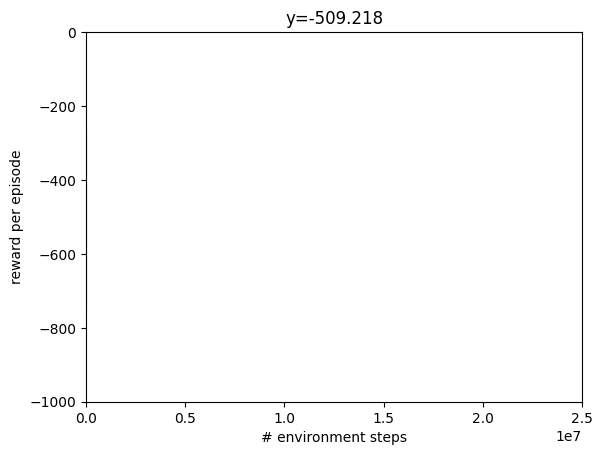

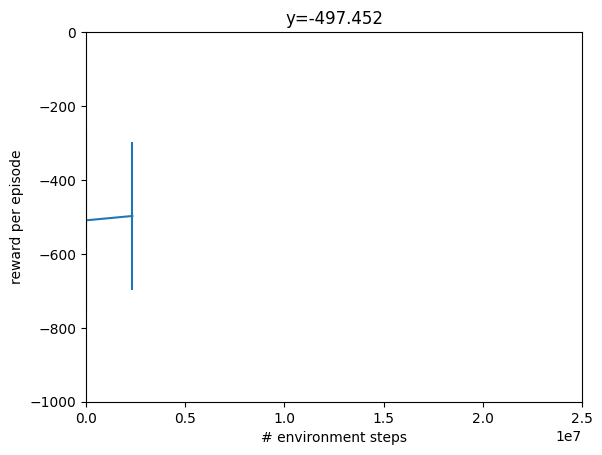

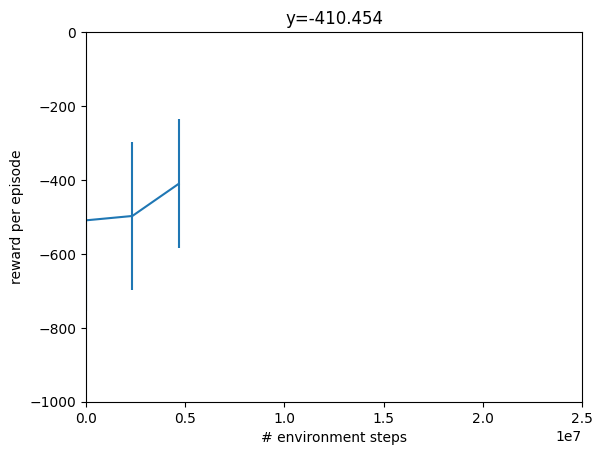

In [ ]:
import functools
import matplotlib.pyplot as plt

from datetime import datetime
from brax.training.agents.ppo import train as ppo
from brax.training.agents.es import train as es

train_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000,
    num_evals=10,
    reward_scaling=0.1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=24,
    num_updates_per_batch=8,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-3,
    num_envs=3072,
    batch_size=512,
    seed=0,
)

# train_fn = functools.partial(
#     es.train,
#     population_size=128,
#     num_eval_envs=128,
#     num_timesteps=15_000,
#     episode_length=15_000,
#     max_devices_per_host=8,
#     seed=1,
# )


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 0, -1000


def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([-1, train_fn.keywords["num_timesteps"] * 1.25])
    plt.ylim([min_y, max_y])

    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")

    plt.errorbar(x_data, y_data, yerr=ydataerr)
    plt.show()


make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
model_path = 'mjx_brax_policy'
model.save_params(model_path, params)

params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

# initialize the state
key = jax.random.PRNGKey(0)
state = jit_reset(key)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 1

for i in range(n_steps):
  act_rng, key = jax.random.split(key)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

media.show_video(env.render(rollout[::render_every]), fps=1.0 / env.dt / render_every)

ValueError: The camera "side" does not exist.

In [ ]:
# @title Import Libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from brax import envs
from brax import jumpy as jp
from brax.io import html

import jax
import jax.numpy as jnp
from jax import random

from evojax import SimManager
from evojax import ObsNormalizer
from evojax.algo import PGPE
from evojax.policy import MLPPolicy
from evojax.task.brax_task import BraxTask

import os
if 'COLAB_TPU_ADDR' in os.environ:
    from jax.tools import colab_tpu
    colab_tpu.setup_tpu()

print('jax.devices():')
jax.devices()

#@title Preview a Brax environment { run: "auto" }
#@markdown Select the environment to train:
env_name = "sequential_reacher"  # @param ['ant', 'humanoid', 'halfcheetah', 'fetch']
env_fn = envs.create_fn(env_name=env_name, legacy_spring=True)
env = env_fn()
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

# @title Set hyper-parameters
# @markdown PLEASE NOTE: `pop_size` and `num_tests` should be multiples of `jax.local_device_count()`.

n_devices = jax.local_device_count()

pop_size = 1024  # @param
num_tests = 128  # @param
assert pop_size % n_devices == 0
assert num_tests % n_devices == 0

max_iters = 300  # @param
center_lr = 0.01  # @param
init_std = 0.04  # @param
std_lr = 0.07  # @param

seed = 42  # @param

# @title Training
train_task = BraxTask(env_name=env_name, test=False)
test_task = BraxTask(env_name=env_name, test=True)
    
policy = MLPPolicy(
    input_dim=train_task.obs_shape[0],
    output_dim=train_task.act_shape[0],
    hidden_dims=[32, 32, 32, 32],
)
print('#params={}'.format(policy.num_params))

solver = PGPE(
    pop_size=pop_size,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=center_lr,
    stdev_learning_rate=std_lr,
    init_stdev=init_std,
    seed=seed,
)
obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape)
sim_mgr = SimManager(
    n_repeats=1,
    test_n_repeats=1,
    pop_size=pop_size,
    n_evaluations=num_tests,
    policy_net=policy,
    train_vec_task=train_task,
    valid_vec_task=test_task,
    seed=seed,
    obs_normalizer=obs_normalizer,
)

print('Start training Brax ({}) for {} iterations.'.format(env_name, max_iters))
start_time = time.perf_counter()
for train_iters in range(max_iters):
  
  # Training.
  params = solver.ask()
  scores, _ = sim_mgr.eval_params(params=params, test=False)
  solver.tell(fitness=scores)

  # Test periodically.
  if train_iters > 0 and train_iters % 10 == 0:
      best_params = solver.best_params
      scores = np.array(sim_mgr.eval_params(params=best_params, test=True)[0])
      score_avg = np.mean(scores)
      score_std = np.std(scores)
      print('Iter={0}, #tests={1}, score.avg={2:.2f}, score.std={3:.2f}'.format(
          train_iters, num_tests, score_avg, score_std))

# Final test.
best_params = solver.best_params
scores = np.array(sim_mgr.eval_params(params=best_params, test=True)[0])
score_avg = np.mean(scores)
score_std = np.std(scores)
print('Iter={0}, #tests={1}, score.avg={2:.2f}, score.std={3:.2f}'.format(
    train_iters, num_tests, score_avg, score_std))
print('time cost: {}s'.format(time.perf_counter() - start_time))

# @title Visualize the trained policy
task_reset_fn = jax.jit(env.reset)
policy_reset_fn = jax.jit(policy.reset)
step_fn = jax.jit(env.step)
act_fn = jax.jit(policy.get_actions)
obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

best_params = solver.best_params
obs_params = sim_mgr.obs_params

total_reward = 0
rollout = []
rng = jax.random.PRNGKey(seed=42)
task_state = task_reset_fn(rng=rng)
policy_state = policy_reset_fn(task_state)

while not task_state.done:
  rollout.append(task_state)
  task_state = task_state.replace(
    obs=obs_norm_fn(task_state.obs[None, :], obs_params))
  act, policy_state = act_fn(task_state, best_params[None, :], policy_state)
  task_state = step_fn(task_state, act[0])
  total_reward = total_reward + task_state.reward

print('rollout reward = {}'.format(total_reward))
HTML(html.render(env.sys, [s.qp for s in rollout]))